In [86]:
import os
from os.path import join as oj
import sys, time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data_pecarn
import data_psrc
import data
import train
import matplotlib.gridspec as grd
import viz
import style
from style import *

# sns.set(style="black")
# plt.style.use('dark_background')
outcome_def = 'iai_intervention' # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# combined

In [87]:
dummy = True
df_pecarn = data_pecarn.get_data(dummy=dummy)
feat_names, pecarn_feat_names = data.get_feat_names(df_pecarn)

df_psrc = data_psrc.get_data(dummy=dummy)
feat_names, psrc_feat_names = data.get_feat_names(df_psrc)

computing pecarn preprocessing...
computing psrc preprocessing...


In [96]:
feat_names = [k for k in psrc_feat_names if k in pecarn_feat_names]
meta = [outcome_def, 'cv_fold', 'dset']
common_feats = feat_names + meta
df1 = df_pecarn[common_feats]
df2 = df_psrc[common_feats]
df = df1.append(df2) # pd.concat((df1, df2), axis=0)


df = df[df.cv_fold.isin(data.pecarn_train_idxs)] # only use train idxs
# don't include doubles for binary features

processed_feats = data.select_final_feats(feat_names)
print(len(feat_names), feat_names, '\n\n', len(processed_feats), processed_feats)

44 ['VomitWretch_unknown', 'AbdTrauma_yes', 'AbdDistention_no', 'Race_White', 'MOI_Bike collision/fall', 'GCSScore_Full_no', 'AbdomenPain_yes', 'MOI_Motorcycle/ATV/Scooter collision', 'Race_unknown', 'MOI_Fall from an elevation', 'VomitWretch_yes', 'AbdTrauma_no', 'DecrBreathSound_yes', 'CostalTender', 'Race_Asian', 'AbdDistention_unknown', 'Hypotension', 'SeatBeltSign_yes', 'DecrBreathSound_no', 'ThoracicTrauma_yes', 'MOI_Pedestrian/bicyclist struck by moving vehicle', 'AbdTrauma_or_SeatBeltSign_no', 'AbdTenderDegree_unknown', 'GCSScore_Full_yes', 'AbdTenderDegree_Severe', 'AbdomenPain_no', 'InitSysBPRange', 'MOI_Motor vehicle collision', 'RtCostalTender', 'SeatBeltSign_no', 'MOI_unknown', 'VomitWretch_no', 'Race_Black or African American', 'AbdDistention_yes', 'AbdTenderDegree_Moderate', 'AbdTrauma_or_SeatBeltSign_yes', 'Age', 'MOI_Object struck abdomen', 'LtCostalTender', 'GCSScore', 'Race_American Indian or Alaska Native', 'InitHeartRate', 'ThoracicTrauma_no', 'AbdTenderDegree_Mild

In [ ]:
corrs = df[feat_names].corr()
sns.clustermap(corrs, cmap=style.cmap_div)
plt.savefig('results/corrplot.png', dpi=300, bbox_inches='tight')

# features scatter plots

## continuous features

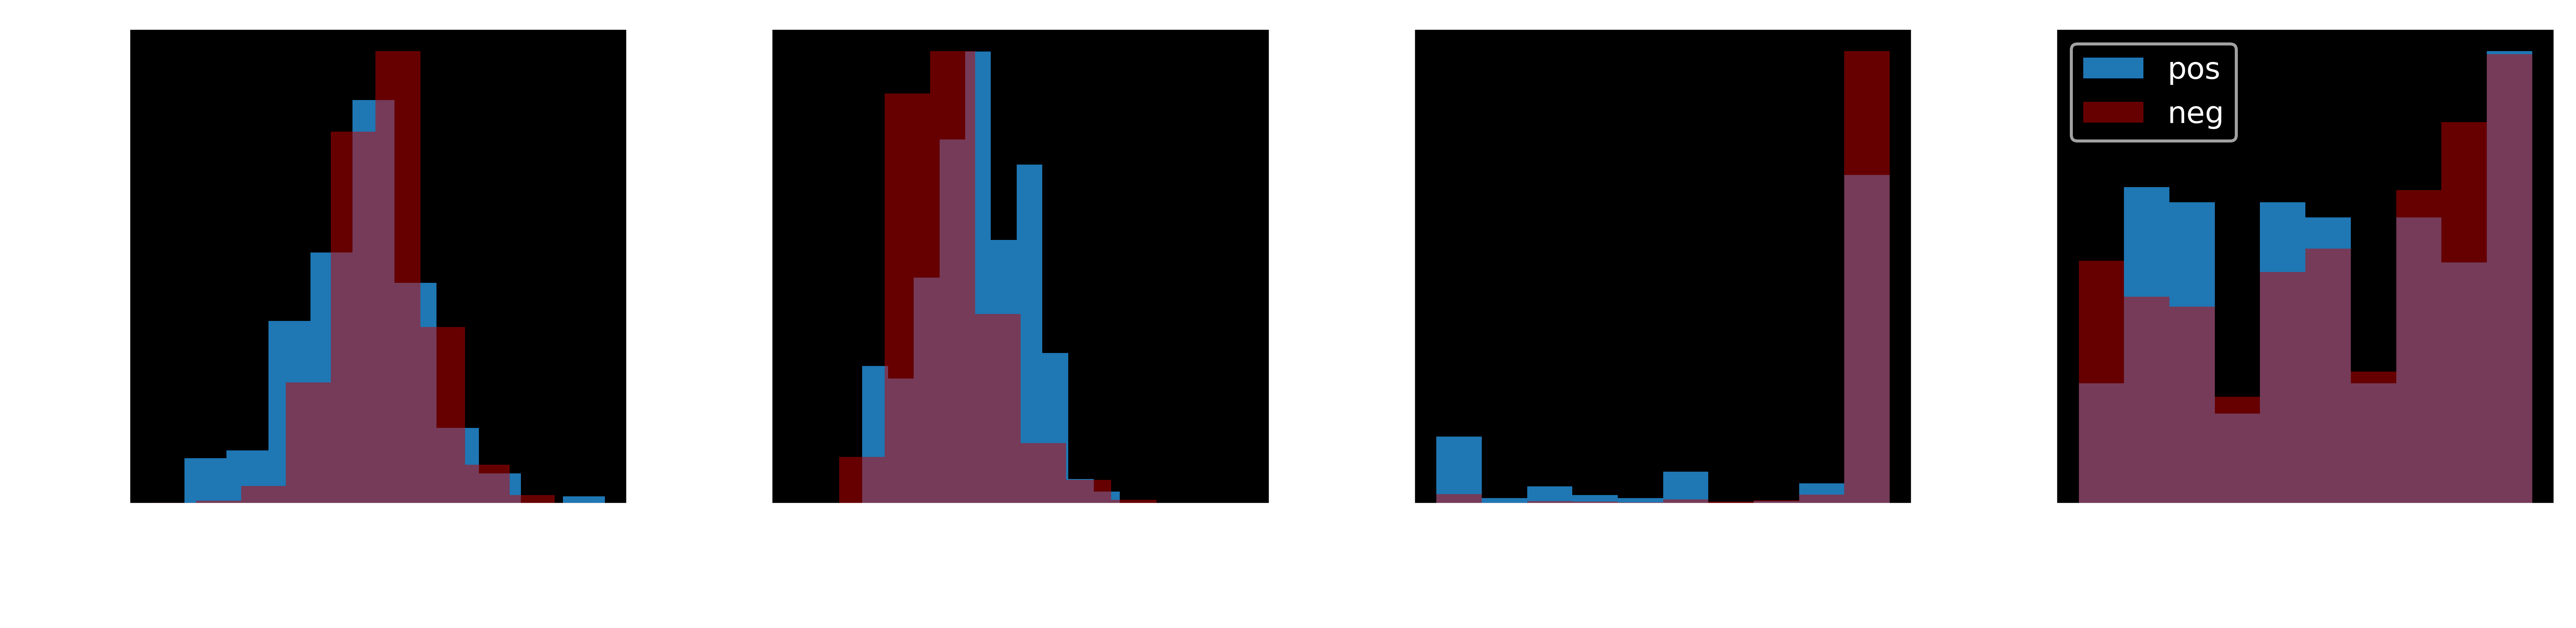

In [75]:
R, C, = 1, 4
plt.figure(figsize=(12, 3), dpi=500)
for i in range(len(data.feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = data.feats_numerical[i]
    plt.hist(df[df[outcome_def] == 1][feat], density=True, alpha=1, label='pos', color=cb)
    plt.hist(df[df[outcome_def] == 0][feat], density=True, alpha=0.5, label='neg', color=cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

**we can cut GCSScore as whether it is 15 or not (14 is already pretty bad)**

In [79]:
feat = 'GCSScore'
print(np.unique(df[df[outcome_def] == 1][feat], return_counts=True))
print(np.unique(df[df[outcome_def] == 0][feat], return_counts=True))

(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13., 14., 15.]), array([22,  1,  2,  6,  3,  2,  5,  6,  1,  7, 19, 93]))
(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]), array([ 176,   22,   25,   56,   48,   31,   50,   46,   53,   71,  186,
        535, 8605]))


## binary feats

**venn plot**

In [ ]:
# df['CostalTender'] = ((df['LtCostalTender'] == 1) | (df['RtCostalTender'] == 1)) * 1
from matplotlib_venn import venn2
cind = df[df['LtCostalTender']==1].index.values
rind = df[df['CostalTender']==1].index.values
venn2((set(cind), set(rind)))
plt.show()